In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 10 August 2024

# TODO Plot multple station on the final plot!!!

"""
Load full GNSS data for selected stations.
Find instantaneous velocity and smooth.
Plot figure 6
"""

# Imports
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.timeseries import LombScargle

import pandas as pd
import numpy as np
import scipy


import pyTMD.io
import pyTMD.time
import timescale

In [2]:
# Load data for selected stations
# Zachary Katz
# zachary_katz@mines.edu
# October 2024

# Make input for LEASTSQUARESGMT.sh

# Imports
import sys

sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog",
)
import Catalog
import logging

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas =  ["la09","la07","la10","gz01"
        ]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
year_arr = [["2007","2008","2009","2010","2011","2012",'2013','2014','2015',"2016","2017","2018","2019"]]

# Detection parameters
max_gap_len = 60 * 60 * 24 # 24 hr # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 


# fmt: on
########################## User Defined Variables ##############################
################################################################################


def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [3]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)

    picks.lls_detection(window, slide)
    sorted_list = picks.on_off_list()

2024-10-24 12:41:44 __main__ INFO: Creating Dataframe for la09
2024-10-24 12:51:02 __main__ INFO: Interpolating la09
2024-10-24 12:51:02 Catalog INFO: 2010-02-07 20:59:45 2010-02-07 22:00:00 0 days 01:00:15
2024-10-24 12:51:10 Catalog INFO: 2010-04-03 04:49:15 2010-04-03 04:49:45 0 days 00:00:30
2024-10-24 12:51:17 Catalog INFO: 2010-04-10 11:59:45 2010-04-10 15:00:00 0 days 03:00:15
2024-10-24 12:51:22 Catalog INFO: 2010-04-13 07:59:45 2010-04-13 09:00:00 0 days 01:00:15
2024-10-24 12:51:28 Catalog INFO: 2010-04-13 17:59:45 2010-04-13 19:00:00 0 days 01:00:15
2024-10-24 12:51:33 Catalog INFO: 2010-04-14 19:59:45 2010-04-14 21:00:00 0 days 01:00:15
2024-10-24 12:51:39 Catalog INFO: 2010-04-29 23:29:00 2010-04-29 23:30:00 0 days 00:01:00
2024-10-24 12:51:44 Catalog INFO: 2010-04-29 23:30:15 2010-04-29 23:33:00 0 days 00:02:45
2024-10-24 12:51:49 Catalog INFO: 2010-04-29 23:33:15 2010-04-29 23:34:30 0 days 00:01:15
2024-10-24 12:51:54 Catalog INFO: 2010-04-29 23:35:15 2010-04-29 23:36:15

In [4]:
# Find instantaneous velocity and smooth
def derivative(time, x_col, freq):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of

    Returns
    grad - First derivative [list]
    grad2 - Second derivative [list]
    """
    y_data = x_col - np.mean(x_col)
    # print(x_data,y_data)
    try:
        b, a = scipy.signal.butter(4, freq, "low")
        filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
        grad = np.gradient(filtered, 15)

        b, a = scipy.signal.butter(4, 0.05)
        grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
        grad2 = np.gradient(np.gradient(grad_filtered), 15)
    except ValueError:
        grad = np.full(len(y_data), np.nan)
        grad2 = np.full(len(y_data), np.nan)
    return grad, grad2

In [5]:
for sta in picks.stas:
    _start = sorted_list[sorted_list["station"] == sta.name]
    start = _start[_start["onset"]]
    _end = sorted_list[sorted_list["station"] == sta.name]
    end = _start[not start["onset"]]
    print(start[:20])
    print(end[:20])

                  times  onset station
2   2010-02-05 21:53:00   True    la09
80  2011-08-12 13:57:45   True    la09
85  2011-08-14 19:46:30   True    la09
92  2011-08-22 07:42:15   True    la09
97  2011-09-06 20:55:30   True    la09
99  2011-09-08 20:41:00   True    la09
117 2012-07-21 03:17:15   True    la09
124 2012-07-31 19:04:15   True    la09
128 2012-08-12 09:06:15   True    la09
131 2012-08-20 17:09:45   True    la09
133 2012-08-22 04:08:15   True    la09
141 2012-09-02 23:57:45   True    la09
149 2012-09-08 23:13:45   True    la09
156 2012-09-11 22:39:15   True    la09
158 2012-09-15 17:50:30   True    la09
161 2012-09-17 17:47:45   True    la09
173 2013-07-19 13:49:30   True    la09
177 2013-07-22 16:44:30   True    la09
185 2013-08-10 04:07:15   True    la09
193 2013-08-26 04:04:45   True    la09
                  times  onset station
78  2011-08-03 00:59:30  False    la09
81  2011-08-12 17:46:15  False    la09
86  2011-08-15 01:33:30  False    la09
93  2011-08-23 03:59:30  

In [6]:
sta_dfs = []
for sta in picks.stas:
    dfs = []
    _start = sorted_list[sorted_list["station"] == sta.name]
    start = _start[_start["onset"]]
    _end = sorted_list[sorted_list["station"] == sta.name]
    end = _start[not _start["onset"]]

    for st, ed in zip(start["times"], end["times"]):
        st_index = sta.data[sta.data["time"] == st].index[0]
        ed_index = sta.data[sta.data["time"] == ed].index[0]
        df = sta.data[st_index:ed_index]
        g1, g2 = derivative(df["time"], df["x"], 0.05)
        df["velocity"] = g1
        dfs.append(df)

    sta_dfs.append(dfs)

/tmp/ipykernel_4109/3518714912.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['velocity'] = g1
/tmp/ipykernel_4109/3518714912.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['velocity'] = g1
/tmp/ipykernel_4109/3518714912.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [7]:
# Compute 45 day rolling average of velocity
# Find 45 days in terms of 15 sec observations
# 45 days * 24 hours * 60 minutes * 60 seconds / 15 seconds
obs_num = int(45 * 24 * 60 * 60 / 15)
for sta in sta_dfs:
    for df in sta:
        df["velocity_30"] = (
            df["velocity"].rolling(window=obs_num, center=True).mean()
        )  # m / sec
        df["velocity_30"] = df["velocity_30"] * 3600 * 24 * 365  # m / year

/tmp/ipykernel_4109/2275817414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['velocity_30'] = df['velocity'].rolling(window=obs_num,center=True).mean() # m / sec
/tmp/ipykernel_4109/2275817414.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['velocity_30'] = df['velocity_30'] * 3600 * 24 * 365 # m / year
/tmp/ipykernel_4109/2275817414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [8]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv("EventStartTime.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Find times with no data
no_data = {"interval": [], "starts": [], "ends": []}
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        if diff > datetime.timedelta(days=2):
            no_data["starts"].append(ev_data["ev_time"][i - 1])
            no_data["ends"].append(ev_data["ev_time"][i])
            no_data["interval"].append(diff)


def tides(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    c = constituents.fields
    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

In [9]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2008-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 11 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]


for lat, lon, place in zip(lats, lons, places):
    ev_data[f"tides{place}"] = tides(dates_timeseries, lat, lon)

TMD3


Text(-0.08, 0.95, 'b.')

/home/zkatz/miniconda3/envs/gps/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/zkatz/miniconda3/envs/gps/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


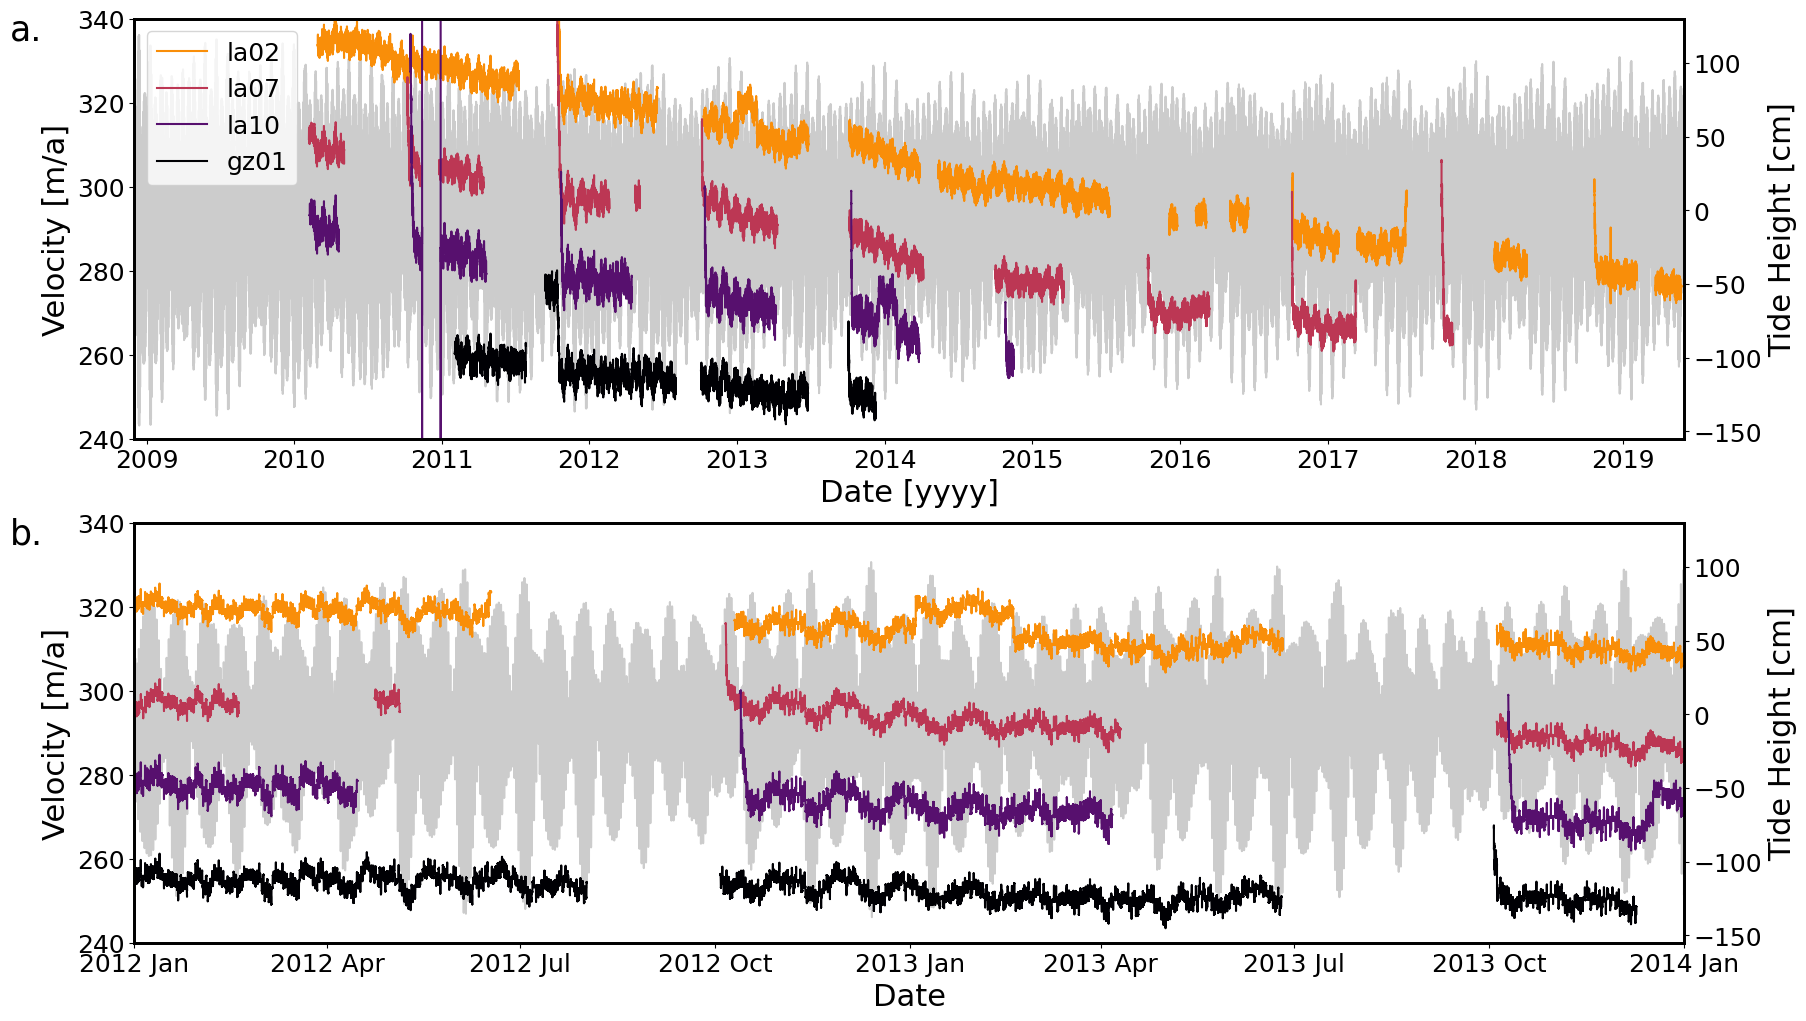

In [11]:
stas = ["la02", "la07", "la10", "gz01"]
fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))

# colors = ["#f5db4c", "#f78410", "#cb4149", "#85216b", "#390963", "#000004"]
colors = [
    "#f98e09",
    "#bc3754",
    "#57106e",
    "#000004",
]

(ax1.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    # ax1.add_patch(rect)
ax1.set_ylim(-155, 130)

ax2 = ax1.twinx()

for p, sta in enumerate(sta_dfs):
    for q, df in enumerate(sta):
        if q == 0:
            ax2.plot(df["time"], df["velocity_30"], label=stas[p], color=colors[p])
        else:
            ax2.plot(df["time"], df["velocity_30"], color=colors[p])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax1.set_xlabel("Date [yyyy]", size=22)
ax1.set_ylabel("Tide Height [cm]", size=22)
ax2.set_ylabel("Velocity [m/a]", size=22)
ax2.set_ylim(240, 340)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.legend(fontsize=18)
ax1.set_xlim(datetime.datetime(2008, 12, 1), datetime.datetime(2019, 6, 1))


(ax3.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    # ax1.add_patch(rect)
ax3.set_ylim(-155, 130)
ax4 = ax3.twinx()

for p, sta in enumerate(sta_dfs):
    for q, df in enumerate(sta):
        if q == 0:
            ax4.plot(df["time"], df["velocity_30"], label=stas[p], color=colors[p])
        else:
            ax4.plot(df["time"], df["velocity_30"], color=colors[p])

ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax4.yaxis.set_label_position("left")
ax4.yaxis.tick_left()
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))

ax3.set_xlabel("Date", size=22)
ax3.set_ylabel("Tide Height [cm]", size=22)
ax4.set_ylabel("Velocity [m/a]", size=22)

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)
ax3.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2014, 1, 1))
ax4.set_ylim(240, 340)

ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax3.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

In [82]:
# Spectrograms
i = 0
avg_vel_detrendeds = []
dates_as_secs = []
for i in [0, 1, 2, 3]:
    sta_df = pd.concat(sta_dfs[i])
    dates_as_sec = [a.timestamp() for a in sta_df["time"]]
    avg_vel_masked = np.ma.masked_array(
        sta_df["velocity_30"], mask=np.invert(~np.isnan(sta_df["velocity_30"]))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(sta_df["velocity_30"]))
    )

    avg_vel_masked = np.ma.compressed(avg_vel_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    avg_vel_detrended = scipy.signal.detrend(avg_vel_masked)
    avg_vel_detrendeds.append(avg_vel_detrended)
    dates_as_secs.append(dates_as_sec_masked)

In [101]:
# Downsample to make lomb-scargle tractable
dates_as_secs_downsampled = []
avg_vel_detrendeds_downsampled = []
# Downsample to every 6 hours
# 6 hours * 60 minutes * 60 seconds / 15 seconds = 144
for i in range(4):
    dates_as_secs_downsampled.append(dates_as_secs[i][::180])
    avg_vel_detrendeds_downsampled.append(avg_vel_detrendeds[i][::180])

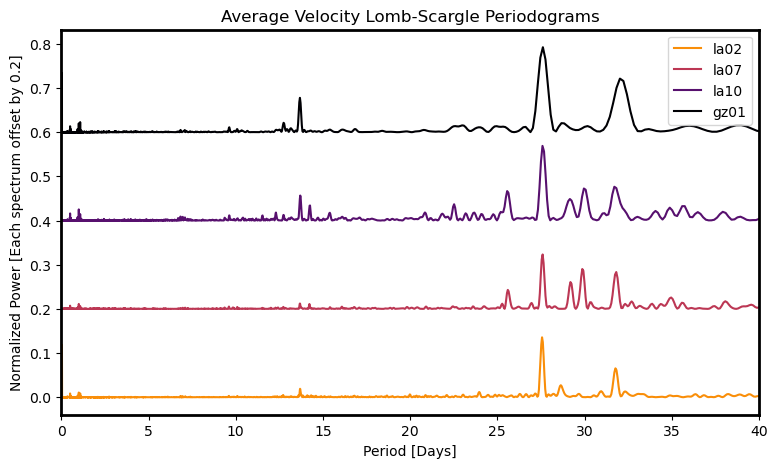

In [102]:
# Spectrogram of rolling avg slips using lomb scargle
fig, ax = plt.subplots(figsize=(9, 5))
offset = 0
colors = ["#f98e09", "#bc3754", "#57106e", "#000004"]
stas = ["la02", "la07", "la10", "gz01"]
for avg_vel_detrended, dates_as_sec_masked, color, sta in zip(
    avg_vel_detrendeds_downsampled, dates_as_secs_downsampled, colors, stas
):
    frequency, power = LombScargle(dates_as_sec_masked, avg_vel_detrended).autopower()
    pks = scipy.signal.find_peaks(power, height=0.02)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / 3600 / 24  # days
    ax.plot(period, power + offset, color=color, label=sta)
    offset += 0.2
    ax.set_title("Average Velocity Lomb-Scargle Periodograms")
    ax.set_xlabel("Period [Days]")
    ax.set_ylabel("Normalized Power [Each spectrum offset by 0.2]")
    ax.set_xlim(0, 40)
    # ax.set_ylim(0,2)
    ax.legend()

    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    # for pk, pwr in zip(frequency[pks], power[pks]):
    # if pk < 0.25e-5:
    # print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
    # else:
    # print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
    # print("")

1491.3157894736842 Days, Power = 0.26558221782782954
809.5714285714284 Days, Power = 0.021969800461111706
691.0975609756097 Days, Power = 0.035999752732612814
464.50819672131144 Days, Power = 0.06537107784476863
358.67088607594934 Days, Power = 0.047931684884185345
292.11340206185565 Days, Power = 0.18155147460422913
213.04511278195488 Days, Power = 0.03904153034989613
200.95744680851064 Days, Power = 0.057451512935605235
182.80645161290323 Days, Power = 0.03865300848630314
167.6627218934911 Days, Power = 0.05207418135964175
133.0281690140845 Days, Power = 0.07921830603523201
111.99604743083003 Days, Power = 0.06689461132847682
97.37113402061854 Days, Power = 0.028176212714966436
92.29641693811074 Days, Power = 0.027369065626721048
86.12462006079025 Days, Power = 0.04817384144593613
73.59740259740259 Days, Power = 0.032107771951456594
35.64150943396226 Days, Power = 0.02852571787973879
34.93834771886559 Days, Power = 0.022338547958885
31.801346801346796 Days, Power = 0.0723125074012515

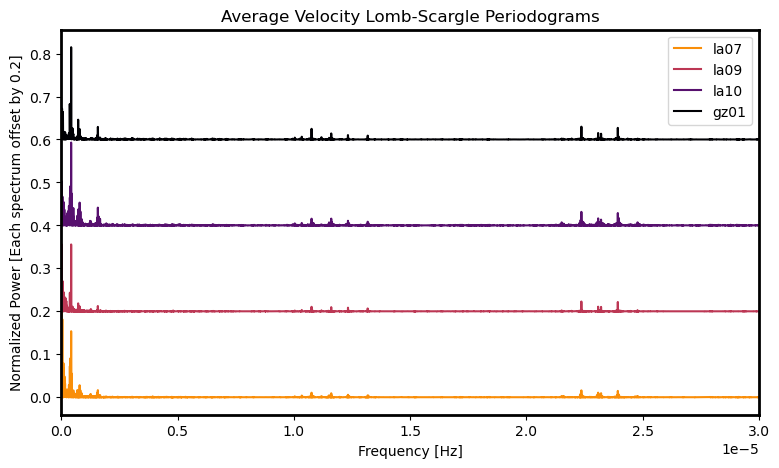

In [22]:
# Spectrogram of rolling avg slips using lomb scargle
fig, ax = plt.subplots(figsize=(9, 5))
offset = 0
colors = ["#f98e09", "#bc3754", "#57106e", "#000004"]
stas = ["la07", "la09", "la10", "gz01"]
for avg_vel_detrended, dates_as_sec_masked, color, sta in zip(
    avg_vel_detrendeds, dates_as_secs, colors, stas
):
    frequency, power = LombScargle(dates_as_sec_masked, avg_vel_detrended).autopower()
    pks = scipy.signal.find_peaks(power, height=0.02)[0]
    # ax.plot(frequency[pks], power[pks], 'ro')
    ax.plot(frequency, power + offset, color=color, label=sta)
    offset += 0.2
    ax.set_title("Average Velocity Lomb-Scargle Periodograms")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Normalized Power [Each spectrum offset by 0.2]")
    ax.set_xlim(0, 3e-5)
    # ax.set_ylim(0,2)
    ax.legend()

    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    for pk, pwr in zip(frequency[pks], power[pks]):
        if pk < 0.25e-5:
            print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
        else:
            print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
    print("")